# emodpy-generic SIR example
This notebook provides a example of using emodpy-generic to commission an EMOD simulation on COMPS with simple SIR dynamics.

First, import the workspace and the emod_api package to verify that our virtual environment is set up and all prerequisite modules are installed. To view the contents of the workspace, see [workspace.py](https://docs.idmod.org/projects/jupyter-notebooks-emodpy/en/latest/generic-supp-files.html#workspace-py).

In [1]:
import workspace

In [2]:
import emod_api

In [3]:
help(emod_api)

Help on package emod_api:

NAME
    emod_api

DESCRIPTION
    To generate a config.json from a param_overrides.json (or params-of-interest.json):
        python -m emod_api.config.from_overrides </path/to/po.json>
    
    To generate a default config.json based on the schema for a given Eradication binary:
        python -m emod_api.config.from_schema -e </path/to/Eradication.[exe]> ...
    
    To generate a schema.json:
        python -m emod_api.schema.get_schema </path/to/Eradication[.exe]>
    
    For rest of emod-api documentation, please go to https://github.com/InstituteforDiseaseModeling/emod-api

PACKAGE CONTENTS
    __main__
    campaign
    channelreports (package)
    config (package)
    demographics (package)
    interventions (package)
    migration (package)
    schema (package)
    schema_to_class
    serialization (package)
    spatialreports (package)
    tabularoutput (package)
    weather (package)

FILE
    /home/idmuser/.local/lib/python3.6/site-packages/emod_

Then import the emodpy_generic package, which contains most of the functionality for configuring EMOD simulations using the generic simtype.

In [4]:
import emodpy_generic

Next we will import the remaining packages. We won't cover these in detail.

In [5]:
import pathlib # for a join
from functools import partial  # for setting Run_Number. In the future, Run_Number will be set by dtk_pre_proc based on generic param_sweep_value...

# idmtools ...
from idmtools.assets import Asset, AssetCollection  #
from idmtools.builders import SimulationBuilder
from idmtools.core.platform_factory import Platform
from idmtools.entities.experiment import Experiment
from idmtools_platform_comps.utils.python_requirements_ac.requirements_to_asset_collection import RequirementsToAssetCollection
from idmtools_models.templated_script_task import get_script_wrapper_unix_task

# emodpy
from emodpy.emod_task import EMODTask

import params
import manifest


/!\ WARNING: File 'idmtools.ini' Not Found! For details on how to configure idmtools, see https://docs.idmod.org/projects/idmtools/en/v1.6.3/configuration.html for details on how to configure idmtools.


You can ignore the warning above. We can run without an idmtools.ini file by passing parameters to Platform directly.

Now let's quickly explore those last two imports. The params and manifest imports are simple name-value pairs. Experiment parameters live in params. All references to input and output file paths live in manifest. See the params module below:

In [6]:
help(params)

Help on module params:

NAME
    params

DATA
    base_infectivity = 1.0
    exp_name = 'SIR Demo'
    nSims = 4

FILE
    /var/tmp/514bdp5b/params.py




Similarly, let's look at the manifest:

In [7]:
help(manifest)

Help on module manifest:

NAME
    manifest

DATA
    assets_input_dir = 'Assets'
    eradication_path = 'stash/Eradication'
    my_ep4_assets = None
    plugins_folder = 'stash'
    requirements = './requirements.txt'
    schema_file = 'stash/schema.json'

FILE
    /var/tmp/514bdp5b/manifest.py




Now let's get the EMOD (DTK) binary and any other associated model runtime files. (Currently, emod_polio contains the most current binary from the Generic-Ongoing branch. If you haven't already, make sure emod_polio has been installed in your current virtual environment.)

In [8]:
import emod_measles.bootstrap as dtk
dtk.setup()

There's no output from running the above two lines, but the EMOD binary was copied into stash/Eradication file on disk and the schema.json file was put into stash/schema.json. You control those paths based on the corresponding entries in manifest.py.

Now we need to specify the "Platform," which is the compute system we are going to run simulations on. The line below targets the Calculon cluster via COMPS. It will prompt you for credentials.

In [9]:
platform = Platform("SLURM", node_group="idm_48cores", priority="Highest")


[SLURM]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Next we will create a "task," which requires us to pass it functions that create the configuration, demographics, and campaign files. So we need to define those functions first.

- set_param_fn is the config function creator. In this case, it sets the simulation to be one year long, but will exit after three months if prevalence goes to zero. It also sets three disease model parameters for infectivity, incubation, and infectious duration.

- build_camp is the campaign builder. This campaign adds an infection-seeding outbreak of one case at timestep one.

- build_demog is the demographics builder. This demographics builder indicates we have a single node with 10,000 people in it.

In [10]:
import emod_api.campaign as camp
import emod_api.interventions.outbreak as ob
camp.schema_path = manifest.schema_file
help(ob)
event = ob.new_intervention( timestep=1, campaign_hook=camp, cases=1 )

Help on module emod_api.interventions.outbreak in emod_api.interventions:

NAME
    emod_api.interventions.outbreak

FUNCTIONS
    new_intervention(timestep, campaign_hook, cases=1)
        Create EMOD-ready Outbreak intervention.
        
        Parameters:
            timestep (float): timestep at which outbreak should occur.
            cases (integer): new parmamter that specifies maximum number of cases. May not be supported.
        
        Returns: 
            event (json): event as dict (json)
    
    new_intervention_as_file(timestep, camp, cases=1, filename=None)
    
    seed_by_coverage(timestep, campaign_hook, coverage=0.01)
        This simple function provides a very common piece of functionality to seed an infection. A future version 
        will support targeted nodesets.

FILE
    /home/idmuser/.local/lib/python3.6/site-packages/emod_api/interventions/outbreak.py


"'Max_Cases_Per_Node' not found in this object. List of keys = odict_keys(['class', 'Demographic_Co

In [11]:
def set_param_fn( config ):
    """
    Simulation will run for a year.
    Base_Infectivity is constant at 3.5 units for each infected person during their entire infectious period.
    There is no incubation period.
    The duration of the infectious period is a random draw from an exponential distribution with mean 4.0.
    All values you don't see are set to the schema defaults.
    """
    config.parameters.Simulation_Duration = 365.0
    config.parameters.Base_Infectivity_Constant = 3.5
    config.parameters.Enable_Demographics_Reporting = 0
    config.parameters.Incubation_Period_Constant = 0
    config.parameters.Infectious_Period_Exponential = 4.0
    config.parameters.Minimum_End_Time = 90
    return config

def build_camp():
    """
    Build a campaign input file for the DTK using emod_api.
    """
    import emod_api.campaign as camp
    import emod_api.interventions.outbreak as ob

    print(f"Telling emod-api to use {manifest.schema_file} as schema.")
    camp.schema_path = manifest.schema_file

    # importation pressure
    event = ob.new_intervention( timestep=1, campaign_hook=camp, cases=1 )
    camp.add( event, first=True )
    return camp

def build_demog():
    """
    Build a demographics input file for the DTK using emod_api. Single node, very simply, 10,000 humans.
    """
    import emodpy_generic.demographics.GenericDemographics as Demographics # OK to call into emod-api

    demog = Demographics.fromBasicNode( lat=0, lon=0, pop=10000, name=1, forced_id=1 )
    return demog

Now we are ready to create the "task". from_default(2) is the main function we use for this. All parameters not specified are schema defaults. You can inspect the schema file if interested. The created configuration files will be written to your local disk if you run this from the command line.

In [12]:
task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path, campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file, param_custom_cb=set_param_fn, ep4_custom_cb=None)

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7fe2b65b6c80>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Generating demographics file demographics.json.
Telling emod-api to use stash/schema.json as schema.
"'Max_Cases_Per_Node' not found in this object. List of keys = odict_keys(['class', 'Demographic_Coverage', 'ID_List', 'Intervention_Config', 'Max_Distributions_Per_Node', 'Node_Property_Restrictions', 'Number_Repetitions', 'Property_Restrictions', 'Property_Restrictions_Within_Node', 'Target_Age_Max', 'Target_Age_Min', 'Target_Demographic', 'Target_Gender', 'Target_Residents_Only', 'Timesteps_Between_Repetitions', 'schema'])."
Using 'Outbreak' intervention instead of OutbreakIndividual and Max_Case_Per_Node.
Don't know how to make default for key Sim_Types.
Campaign is listening to the following events:
Campaign is publishing the following events:
Campaign builder save

Finally, we are going to create the "simulation" and the "experiment". An experiment consists of N simulations. This simulation will sweep over a specified number of Run_Numbers (random number seeds). We create a partial function that sets the Run_Number to a new value, and store this with the builder. The number of sweeps is controlled by the smaller params.py file.

In [13]:
def update_sim_random_seed(simulation, value):
    simulation.task.config.parameters.Run_Number = value
    return {"Run_Number": value}


Now we are ready to run our experiment using all the objects we've configured and created.

In [14]:
    # Create simulation sweep with builder
    builder = SimulationBuilder()
    builder.add_sweep_definition( update_sim_random_seed, range(params.nSims) )

    # create experiment from builder
    experiment  = Experiment.from_builder(builder, task, name=params.exp_name)

    # The last step is to call run() on the ExperimentManager to run the simulations.
    experiment.run(wait_until_done=True, platform=platform)



The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=a679e876-5521-ec11-9ecd-9440c9bee941
Simulations are still being created



Waiting on Experiment SIR Demo to Finish running: 100%|██████████| 4/4 [00:25<00:00,  6.44s/simulation]


And then include some code to see if the simulation ran successfully.

In [15]:
    if not experiment.succeeded:
        print(f"Experiment {experiment.uid} failed.\n")
        exit()

    print(f"Experiment {experiment.uid} succeeded.")

Experiment a679e876-5521-ec11-9ecd-9440c9bee941 succeeded.


You can use COMPS to review the output of the simulation, including plots of results. The URL for the simulation is above. We will use a download script to download the results and plot them here. To view the contents of that script, see [downloader.py](downloader.py).

In [16]:
from downloader import download

The experiment ID is copied from the output above and we want to plot InsetChart.json, which is the standard EMOD output file.

In [17]:
def download_and_collect_output( exp_id ):
    download( exp_id, files_to_get="output/InsetChart.json")
    icjs = []
    import json
    import os
    os.listdir(exp_id)
    for sim_dir in os.listdir(exp_id):
            icjs.append( json.loads( open(exp_id + "/" + sim_dir + "/output/InsetChart.json").read() ) )
    return icjs

In [18]:
output_data = download_and_collect_output( experiment.id )


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment a679e876-5521-ec11-9ecd-9440c9bee941 into a679e876-5521-ec11-9ecd-9440c9bee941.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=895b4b85-5521-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment a679e876-5521-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:15<00:00, 15.34s/workitem]

Removing a679e876-5521-ec11-9ecd-9440c9bee941/output.zip
Deleting workitem 895b4b85-5521-ec11-9ecd-9440c9bee941


In [19]:
import matplotlib.pyplot as plt

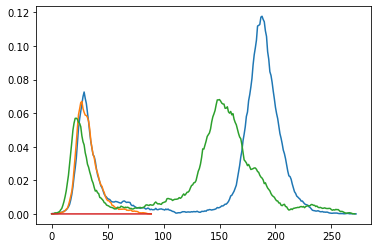

In [20]:
for icj in output_data:
    plt.plot( icj["Channels"]["Infected"]["Data"])

Each of the lines plotted above shows the number of infections over time. Because we ran four simulations with four different random number seeds, we have four different results. In red, we had immediate burnout; the sim runs for the minimum of 90 timesteps. In orange, we had an initial spread and then burned out by day 90. In green and blue we had an initial spread, and then a second wave, with the blue second wave being more delayed and "spikier" than the green.

Now let's increase the original importation event to 10 infected people and re-run the simulations.

In [21]:
def build_camp():
    """
    Build a campaign input file for the DTK using emod_api.
    """
    import emod_api.campaign as camp
    import emod_api.interventions.outbreak as ob

    print(f"Telling emod-api to use {manifest.schema_file} as schema.")
    camp.schema_path = manifest.schema_file

    # importation pressure
    event = ob.new_intervention( timestep=1, campaign_hook=camp, cases=10 )
    camp.add( event, first=True )
    return camp

Regenerate the task.

In [22]:
task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path, campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file, param_custom_cb=set_param_fn, ep4_custom_cb=None)

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7fe2b65b6c80>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Generating demographics file demographics.json.
Telling emod-api to use stash/schema.json as schema.
"'Max_Cases_Per_Node' not found in this object. List of keys = odict_keys(['class', 'Demographic_Coverage', 'ID_List', 'Intervention_Config', 'Max_Distributions_Per_Node', 'Node_Property_Restrictions', 'Number_Repetitions', 'Property_Restrictions', 'Property_Restrictions_Within_Node', 'Target_Age_Max', 'Target_Age_Min', 'Target_Demographic', 'Target_Gender', 'Target_Residents_Only', 'Timesteps_Between_Repetitions', 'schema'])."
Using 'Outbreak' intervention instead of OutbreakIndividual and Max_Case_Per_Node.
Don't know how to make default for key Sim_Types.
Campaign is listening to the following events:
Campaign is publishing the following events:
Campaign builder save

Re-run.

In [23]:
experiment  = Experiment.from_builder(builder, task, name=params.exp_name)
experiment.run(wait_until_done=True, platform=platform)


The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=7268238c-5521-ec11-9ecd-9440c9bee941
Simulations are still being created



Waiting on Experiment SIR Demo to Finish running: 100%|██████████| 4/4 [00:20<00:00,  5.15s/simulation]


Now we copy the experiment number and download the simulation output.

In [24]:
output_data = download_and_collect_output( experiment.id )


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment 7268238c-5521-ec11-9ecd-9440c9bee941 into 7268238c-5521-ec11-9ecd-9440c9bee941.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=21f7b59a-5521-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment 7268238c-5521-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:05<00:00,  5.12s/workitem]

Removing 7268238c-5521-ec11-9ecd-9440c9bee941/output.zip
Deleting workitem 21f7b59a-5521-ec11-9ecd-9440c9bee941


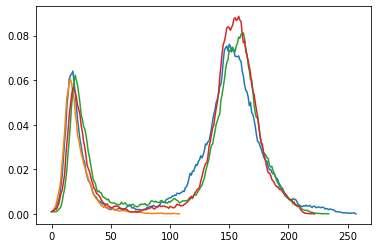

In [25]:
for icj in output_data:
    plt.plot( icj["Channels"]["Infected"]["Data"])

This time, there are no immediate burnouts, one outbreak with a single wave, and three with second waves that start to look similar to each other.

In [26]:
help(params)

Help on module params:

NAME
    params

DATA
    base_infectivity = 1.0
    exp_name = 'SIR Demo'
    nSims = 4

FILE
    /var/tmp/qt9yxs64/params.py




In [27]:
params.nSims = 20

In [28]:
help(params)

Help on module params:

NAME
    params

DATA
    base_infectivity = 1.0
    exp_name = 'SIR Demo'
    nSims = 20

FILE
    /var/tmp/qt9yxs64/params.py




In [29]:
params.exp_name = 'Jonathan Jupyter Tutorial'

In [30]:
builder = SimulationBuilder()
builder.add_sweep_definition( update_sim_random_seed, range(params.nSims) )
experiment  = Experiment.from_builder(builder, task, name=params.exp_name)
experiment.run(wait_until_done=True, platform=platform)


The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=14f27aa1-5521-ec11-9ecd-9440c9bee941
Simulations are still being created



Creating Simulations on Comps: 100%|██████████| 20/20 [00:00<00:00, 43.99simulation/s]     
Waiting on Experiment Jonathan Jupyter Tutorial to Finish running: 100%|██████████| 20/20 [00:30<00:00,  1.53s/simulation]


In [31]:
output_data = download_and_collect_output( experiment.id )


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment 14f27aa1-5521-ec11-9ecd-9440c9bee941 into 14f27aa1-5521-ec11-9ecd-9440c9bee941.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=c4c859b0-5521-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment 14f27aa1-5521-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:10<00:00, 10.15s/workitem]

Removing 14f27aa1-5521-ec11-9ecd-9440c9bee941/output.zip
Deleting workitem c4c859b0-5521-ec11-9ecd-9440c9bee941


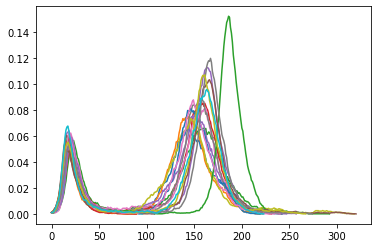

In [32]:
for icj in output_data:
    plt.plot( icj["Channels"]["Infected"]["Data"])

Next let's see what happens if we have a short incubation period for two days.

In [33]:
def set_param_fn( config ):
    """
    Simulation will run for a year.
    Base_Infectivity is constant at 3.5 units for each infected person during their entire infectious period.
    There is no incubation period.
    The duration of the infectious period is a random draw from an exponential distribution with mean 4.0.
    All values you don't see are set to the schema defaults.
    """
    config.parameters.Simulation_Duration = 365.0
    config.parameters.Base_Infectivity_Constant = 3.5
    config.parameters.Enable_Demographics_Reporting = 0
    config.parameters.Incubation_Period_Constant = 2
    config.parameters.Infectious_Period_Exponential = 4.0
    config.parameters.Minimum_End_Time = 90
    return config

In [35]:
def run_and_plot_prev():
    task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path, campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file, param_custom_cb=set_param_fn, ep4_custom_cb=None)
    experiment  = Experiment.from_builder(builder, task, name=params.exp_name)
    experiment.run(wait_until_done=True, platform=platform)
    output_data = download_and_collect_output( experiment.id )
    for icj in output_data:
        plt.plot( icj["Channels"]["Infected"]["Data"])

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7fe29d111c80>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Generating demographics file demographics.json.
Telling emod-api to use stash/schema.json as schema.
"'Max_Cases_Per_Node' not found in this object. List of keys = odict_keys(['class', 'Demographic_Coverage', 'ID_List', 'Intervention_Config', 'Max_Distributions_Per_Node', 'Node_Property_Restrictions', 'Number_Repetitions', 'Property_Restrictions', 'Property_Restrictions_Within_Node', 'Target_Age_Max', 'Target_Age_Min', 'Target_Demographic', 'Target_Gender', 'Target_Residents_Only', 'Timesteps_Between_Repetitions', 'schema'])."
Using 'Outbreak' intervention instead of OutbreakIndividual and Max_Case_Per_Node.
Don't know how to make default for key Sim_Types.
Campaign is listening to the following events:
Campaign is publishing the following events:
Campaign builder save

Creating Simulations on Comps: 100%|██████████| 20/20 [00:00<00:00, 53.70simulation/s]     
Waiting on Experiment Jonathan Jupyter Tutorial to Finish running: 100%|██████████| 20/20 [00:05<00:00,  3.91simulation/s]


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment 8acee247-5621-ec11-9ecd-9440c9bee941 into 8acee247-5621-ec11-9ecd-9440c9bee941.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=17cfe247-5621-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment 8acee247-5621-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:10<00:00, 10.15s/workitem]

Removing 8acee247-5621-ec11-9ecd-9440c9bee941/output.zip
Deleting workitem 17cfe247-5621-ec11-9ecd-9440c9bee941


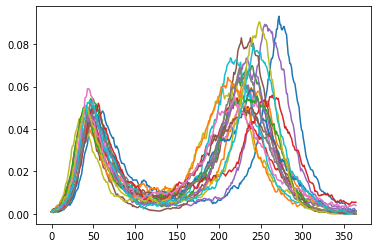

In [36]:
run_and_plot_prev()

As we'd expect, adding an incubation period shifts everything to the right  and also increase trace-to-trace variability.

Now let's increase infectivity from 3.5 to 5.0.

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7fe29d09e9d8>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Generating demographics file demographics.json.
Telling emod-api to use stash/schema.json as schema.
"'Max_Cases_Per_Node' not found in this object. List of keys = odict_keys(['class', 'Demographic_Coverage', 'ID_List', 'Intervention_Config', 'Max_Distributions_Per_Node', 'Node_Property_Restrictions', 'Number_Repetitions', 'Property_Restrictions', 'Property_Restrictions_Within_Node', 'Target_Age_Max', 'Target_Age_Min', 'Target_Demographic', 'Target_Gender', 'Target_Residents_Only', 'Timesteps_Between_Repetitions', 'schema'])."
Using 'Outbreak' intervention instead of OutbreakIndividual and Max_Case_Per_Node.
Don't know how to make default for key Sim_Types.
Campaign is listening to the following events:
Campaign is publishing the following events:
Campaign builder save

Creating Simulations on Comps: 100%|██████████| 20/20 [00:01<00:00, 14.47simulation/s]     
Waiting on Experiment Jonathan Jupyter Tutorial to Finish running: 100%|██████████| 20/20 [00:30<00:00,  1.54s/simulation]


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment 749561ce-5621-ec11-9ecd-9440c9bee941 into 749561ce-5621-ec11-9ecd-9440c9bee941.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=a0d324e1-5621-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment 749561ce-5621-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:10<00:00, 10.12s/workitem]

Removing 749561ce-5621-ec11-9ecd-9440c9bee941/output.zip
Deleting workitem a0d324e1-5621-ec11-9ecd-9440c9bee941


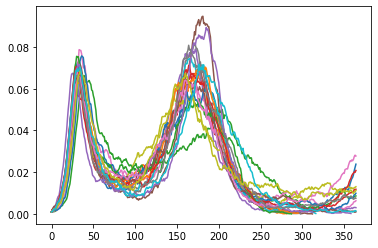

In [37]:
def set_param_fn( config ):
    """
    Simulation will run for a year.
    Base_Infectivity is constant at 3.5 units for each infected person during their entire infectious period.
    There is no incubation period.
    The duration of the infectious period is a random draw from an exponential distribution with mean 4.0.
    All values you don't see are set to the schema defaults.
    """
    config.parameters.Simulation_Duration = 365.0
    config.parameters.Base_Infectivity_Constant = 5.0
    config.parameters.Incubation_Period_Constant = 2
    config.parameters.Infectious_Period_Exponential = 4.0
    config.parameters.Minimum_End_Time = 90
    return config

run_and_plot_prev()

Increasing infectivity shows what appears to be a third wave of infections at the end of the year-long simulation. Let's run the simulation for two years to see how transmission dynamics change over a longer period.

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7fe29df57950>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Generating demographics file demographics.json.
Telling emod-api to use stash/schema.json as schema.
"'Max_Cases_Per_Node' not found in this object. List of keys = odict_keys(['class', 'Demographic_Coverage', 'ID_List', 'Intervention_Config', 'Max_Distributions_Per_Node', 'Node_Property_Restrictions', 'Number_Repetitions', 'Property_Restrictions', 'Property_Restrictions_Within_Node', 'Target_Age_Max', 'Target_Age_Min', 'Target_Demographic', 'Target_Gender', 'Target_Residents_Only', 'Timesteps_Between_Repetitions', 'schema'])."
Using 'Outbreak' intervention instead of OutbreakIndividual and Max_Case_Per_Node.
Don't know how to make default for key Sim_Types.
Campaign is listening to the following events:
Campaign is publishing the following events:
Campaign builder save

Creating Simulations on Comps: 100%|██████████| 20/20 [00:01<00:00, 12.17simulation/s]     
Waiting on Experiment Jonathan Jupyter Tutorial to Finish running: 100%|██████████| 20/20 [00:25<00:00,  1.30s/simulation]


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment dfd0c61e-5721-ec11-9ecd-9440c9bee941 into dfd0c61e-5721-ec11-9ecd-9440c9bee941.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=6444092c-5721-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment dfd0c61e-5721-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:05<00:00,  5.20s/workitem]

Removing dfd0c61e-5721-ec11-9ecd-9440c9bee941/output.zip
Deleting workitem 6444092c-5721-ec11-9ecd-9440c9bee941


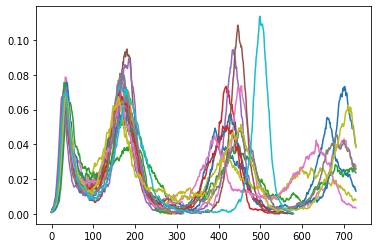

In [38]:
def set_param_fn( config ):
    """
    Simulation will run for 2 years.
    Base_Infectivity is constant now at 5 units for each infected person during their entire infectious period.
    There is a small incubation period.
    The duration of the infectious period is a random draw from an exponential distribution with mean 4.0.
    All values you don't see are set to the schema defaults.
    """
    config.parameters.Simulation_Duration = 730.0
    config.parameters.Base_Infectivity_Constant = 5.0
    config.parameters.Incubation_Period_Constant = 2
    config.parameters.Infectious_Period_Exponential = 4.0
    config.parameters.Minimum_End_Time = 90
    return config

run_and_plot_prev()